# BlackLitterman Model

Este modelo facilita la integración de nuestras perspectivas de mercado con las expectativas implícitas del mercado en equilibrio, lo que permite derivar una asignación óptima de activos. Resulta especialmente valioso para perfeccionar el proceso de optimización media-varianza, ya que garantiza que el portafolio refleje tanto nuestras convicciones como el consenso del mercado.

In [99]:
# importing the warnings library
import warnings ; warnings.filterwarnings("ignore")
# importing the numpy library as np for numerical operations
import numpy as np 
# importing the pandas library as pd for data manipulation and analysis
import pandas as pd  
# importing the pyplot module from matplotlib as plt for plotting data
import matplotlib.pyplot as plt 
# importing the seaborn library as sns for statistical data visualization
import seaborn as sns  
# setting the seaborn style to "whitegrid" for subsequent plots
sns.set_style("darkgrid")  
# importing YieldCurve from pyriskmgmt.fixed_income_models for fixed income analysis
from pyriskmgmt.fixed_income_models import YieldCurve 
# importing itertools for pair-wise computation
import itertools
# importing the module to perform the regression analysis
import statsmodels.api as sm
# importing the minimize function for optimization
from scipy.optimize import minimize
# importing the norm function for VaR and Es Calculations
from scipy.stats import norm
# importing the Parallel, delayed, in order to speed up the Monte Carlo simulation of the Var - Es
from joblib import Parallel, delayed
# importing PrettyTable for clear output 
from prettytable import PrettyTable

In [100]:
import json

with open('data/variables.json') as f:
    variables = json.load(f)

variables

{'RiskFree': 0.003675,
 'SharpeRatio': 0.1301,
 'SortinoRatio': 0.1757,
 'VTI_ExpectedReturn': 0.0096,
 'VTI_Std': 0.0452,
 'Delta': 2.9001,
 'tau': 0.05}

## Risk Aversion coefficient in BL Model ($\delta$)

1. **Market Equilibrium:** En el modelo BL, se parte del supuesto que la cartera de mercado (basada en capitalización) es la óptima, al ser un punto de partida racional que evita sesgos extremos.
2. **Investor Views:** Los inversores pueden tener sus opiniones sobre el rendimiento de algunos activos.

El coeficiente de aversión al riesgo cuantifica el grado en que el mercado evita asumir riesgos. Un valor más alto de este coeficiente implica que es más adverso al riesgo, por lo que exige una mayor rentabilidad a cambio de asumir un riesgo adicional. Por el contrario, un valor más bajo indica una menor aversión al riesgo. Este coeficiente es fundamental en el modelo de Black-Litterman, ya que permite ajustar los rendimientos de equilibrio del mercado según el nivel de aversión al riesgo, facilitando así el proceso de optimización de carteras.

$$
\text{$\delta$} = \frac{r_m- r_f}{\sigma^2_m}
$$


Where:
- $r_m$ = Return of the market portfolio (benchmark - all investable assets weighted by market capitalization) 
- $r_f$ = Risk-free rate  
- $\sigma^2_m$ = Variability of the market portfolio



Se utiliza el benchmark para estimar el coeficiente de aversión al riesgo del mercado porque representa el equilibrio general, y luego se aplica ese mismo coeficiente al portafolio ESG para inferir los retornos implícitos que justificarían sus pesos actuales bajo las condiciones de equilibrio del mercado.

In [101]:
delta = (variables['VTI_ExpectedReturn'] - variables['RiskFree']) / variables['VTI_Std']**2
variables['Delta'] = round(delta,4)

with open('data/variables.json', 'w') as f:
    json.dump(variables, f)

## Implied Monthly returns from current weights 

Se trata de una predicción neutral, que se obtiene a partir de los pesos de capitalización, el factor de aversión al riesgo y la matriz de varianza-covarianza de los retornos.
$$
\text{$\pi$} = \text{$\delta$}\text{$\Sigma$}w
$$


Where:
- $\pi$ = Equilibrium Returns (market capitalization) 
- $\delta$ = Risk aversion coefficient
- $\Sigma$ = Covariance matriz of asset returns -> Volatility and co-movement between different assets.
- w: Market Weights given capitalization.


Al multiplicar los pesos actuales por la matriz de covarianzas y luego escalar el resultado por el coeficiente de aversión al riesgo, obtenemos una estimación de los retornos esperados de cada acción en el portafolio dadas las condiciones actuales. Esta es, esencialmente, una predicción 'neutral' o 'predeterminada' sobre los retornos.


In [102]:
stock_returns = pd.read_csv("data/processed_data/stock_returns.csv", index_col='Unnamed: 0')
Sigma = stock_returns.cov()


In [103]:
weights_df = pd.read_csv("data/processed_data/weights.csv")
w = weights_df['Weight'].values

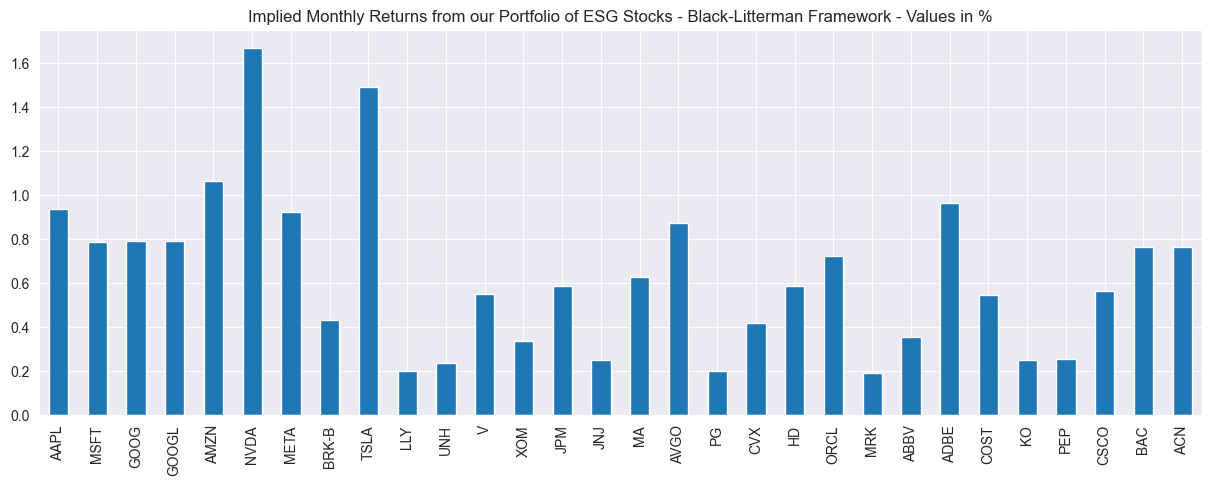

In [104]:
def implied_returns_func(delta,Sigma,w):
    """
    Obtain implied returns Pi, prior estimator
    """
    pi = delta*Sigma.dot(w)
    return pi

pi = implied_returns_func(delta,Sigma,w)
implied_returns_100 = pi*100
implied_returns_100.plot(kind = "bar", figsize = (15,5),
                     title = "Implied Monthly Returns from our Portfolio of ESG Stocks - Black-Litterman Framework - Values in %")
plt.show()

## Black Litterman Model and the Scherer $\Omega$ Uncertainty Matrix

El modelo BL es tá diseñado para integrar las condiciones de equilibrio de mercado con las perspectivas individuales de cada inversor, devolviendo un retorno esperado ajustado, que después es útil para la optimización del portforlio.

$$
\text{$\mu_{BL}$} = \text{$\pi$} + \text{$\tau$}\text{$\Sigma$}P^{T}(P\text{$\tau$}\text{$\Sigma$}P^{T} + \text{$\Omega$})^{-1}(Q-P\text{$\pi$})
$$


## Revisar
$$
\text{$\mu_{BL}$} = \text{$\pi$} + \left[ \text{$\tau$}\text{$\Sigma$}P^{T}(P\text{$\tau$}\text{$\Sigma$}P^{T} + \text{$\Omega$})^{-1}(Q-P\text{$\pi$})
$$

Where:
- $\pi$ = Equilibrium Returns (market capitalization) -> Implied returns
- $\tau$ =  Incertidumbre le asignas a esos retornos de equilibrio
- $\Sigma$ = Covariance matriz of asset returns -> Volatility and co-movement between different assets.
- P = assets to views linking matrix
- Q = vector of views
- $\Omega$ = uncertainty matrix of views

$$
\text{$\Sigma_{BL}$} = \text{$\tau$}\text{$\Sigma$} - \text{$\tau$}\text{$\Sigma$}P^{T}(P\text{$\tau$}\text{$\Sigma$}P^{T} + \text{$\Omega$})^{-1}P\text{$\tau$}\text{$\Sigma$}
$$

$\Omega$ = diag($\omega_1$, ..., $\omega_k$), donde  $\omega_k$ = $\sigma^2_k$(1 - $R^2_k$)


Where:
- $\sigma^2_k$ = variance of the forecast error for the kth view. -> Varianza total del activo al que se refiere la view
- $R^2_k$ = R-squared value for the kth view, indicating the proportion of variance in the asset returns that is explained by the forecasting model. -> Confianza en la view

So, $\omega_k$ represents the unexplained variance of the kth view.


In [220]:
def scherer_omega(unexplained_variances, r2, k):

    omega_diag = np.zeros(k)
    for j in range(len(omega_diag)):
        omega_diag[j] = unexplained_variances[j]*(1-r2[j])
    omega = np.diag(omega_diag)

    return omega



def BlackLittermanFunction(pi,Sigma,P,Q,tau,Omega):

    Sigma_scaled = tau*Sigma
    inv_Sigma_scaled = np.linalg.inv(Sigma_scaled)
    inv_Omega = np.linalg.inv(Omega)
    Q = Q.flatten()
    pi = pi.values

    first_part_mu = np.linalg.inv(inv_Sigma_scaled + P.T @ inv_Omega @ P)
    second_part_mu = inv_Sigma_scaled @ pi + P.T @ inv_Omega @ Q
    
    mu_BL = first_part_mu @ second_part_mu

    Sigma_BL = np.linalg.inv(inv_Sigma_scaled + P.T @ inv_Omega @ P)

    output = {"mu_BL": mu_BL, "Sigma_BL": Sigma_BL}

    return output




### The factor $\tau$

Used to scale the investors uncertainty in their prior estimate of returns.
He-Litterman: $\tau = 0.05$

- $\tau \rightarrow 0$: More weight to market equilibrium
- $\tau \rightarrow 1$: More weight to investors view

In [30]:
tau = 0.05
variables['tau'] = tau

with open('data/variables.json', 'w') as f:
    json.dump(variables, f)

## Estimación de Scherer $\Omega$

### 1. Pairing of Assets

Empezamos formando los pares de stocks de nuestro dataset de rendimientos. Calculamos las diferencias de rendimientos entre cada par de stocks y lo almancenamos en un dataframe de diferencias.

### 2. Regression Analysis &  Extraction of regression results

Sobre el dataframe de diferencias, ejecutamos una regresión lineal sobre los factores macroeconómicos.

$$
y_t = \text{$\alpha$} + \text{$\beta_{1}$} X_{1,t} + \text{$\beta_{2}$} X_{2,t} + ... + \text{$\beta_{F}$} X_{F,t} + \text{$\epsilon_t$}
$$
-> epsilon depende del tiempo lo que el modelo no explico

donde F es el número de factores macroeconómicos.

De cada regresión lineal, hallaremos el alpha mensual, la varianza de residuos y el $R^2$.

### 4. Calculation of $\omega_k$ and construction of $\Omega$

In [33]:
# 1. Pairing Assets
pairs = list(itertools.combinations(stock_returns.columns, 2))
diff_df = pd.DataFrame()

for pair in pairs:
    diff_df[pair] = stock_returns[pair[0]] - stock_returns[pair[1]]

diff_df.head()

,"(AAPL, MSFT)","(AAPL, GOOG)","(AAPL, GOOGL)","(AAPL, AMZN)","(AAPL, NVDA)","(AAPL, META)","(AAPL, BRK-B)","(AAPL, TSLA)","(AAPL, LLY)","(AAPL, UNH)",...,"(KO, PEP)","(KO, CSCO)","(KO, BAC)","(KO, ACN)","(PEP, CSCO)","(PEP, BAC)","(PEP, ACN)","(CSCO, BAC)","(CSCO, ACN)","(BAC, ACN)"
2014-06,0.007433,0.005739,0.010335,-0.005528,0.052769,-0.028270,0.046823,-0.111601,-0.013289,0.006581,...,0.023461,0.025532,0.019753,0.042348,0.002071,-0.003708,0.018887,-0.005779,0.016816,0.022595
2014-07,-0.006087,0.034744,0.037122,0.065303,0.086056,-0.048315,0.037295,0.100699,0.046342,0.032238,...,-0.061218,-0.082918,-0.060547,-0.048256,-0.021700,0.000671,0.012962,0.022371,0.034662,0.012291
2014-08,0.018432,0.069690,0.064853,-0.010257,-0.035956,0.040258,-0.020367,-0.119104,0.029563,0.002532,...,0.011383,0.061964,0.006392,0.037807,0.050581,-0.004991,0.026424,-0.055572,-0.024157,0.031415
2014-09,-0.038750,-0.022285,-0.022594,0.037942,0.036110,-0.067128,-0.018722,0.093308,-0.040368,-0.007286,...,0.015815,0.015104,-0.035671,0.019079,-0.000712,-0.051486,0.003264,-0.050775,0.003975,0.054750
2014-10,0.056843,0.101662,0.105020,0.123587,0.012090,0.122088,0.054972,0.073535,0.046924,-0.031486,...,-0.050853,0.009419,-0.020703,-0.008732,0.060272,0.030150,0.042121,-0.030122,-0.018151,0.011971


In [348]:
def get_views(stock_returns, factor_returns,n_views):
    
    # 1. Pairing Assets
    pairs = list(itertools.combinations(stock_returns.columns, 2))
    diff_df = pd.DataFrame()

    for pair in pairs:
        diff_df[pair] = stock_returns[pair[0]] - stock_returns[pair[1]]

    # 2. Linear Regression
    # Resultados regresión
    regression_results = pd.DataFrame()
    regression_results.index = ['Alpha', 'Var_Residuos', 'R2']

    for col in diff_df:

        # Reg lineal y = (a + bX) + e 
        y = diff_df[col].values

        # Factores son las variables explicativas
        X = factor_returns.values
        X = sm.add_constant(X) # Constant term for alpha

        # Regression model
        modelo = sm.OLS(y,X).fit()

        # Extraemos alpha, R^2 y la varianza de los residuos
        monthly_alpha = modelo.params[0]
        residuals_var =  modelo.resid.var()
        R_squared = modelo.rsquared_adj

        regression_results[col] = [monthly_alpha, residuals_var, R_squared]
    
    # Get Best Views
    
    positive_alpha = regression_results.loc[:, regression_results.loc['Alpha']>0]
    positive_alpha = positive_alpha.transpose()
    top_positive_alpha = positive_alpha.nlargest(n_views, 'R2')
    
    return top_positive_alpha



In [61]:
# 2. Linear Regression 

factor_returns = pd.read_csv("data/processed_data/factor_returns.csv", index_col='Date')

# Resultados regresión
regression_results = pd.DataFrame()
regression_results.index = ['Alpha', 'Var_Residuos', 'R2']

for col in diff_df:

    # Reg lineal y = (a + bX) + e 
    y = diff_df[col].values

    # Factores son las variables explicativas
    X = factor_returns.values
    X = sm.add_constant(X) # Constant term for alpha

    # Regression model
    modelo = sm.OLS(y,X).fit()

    # Extraemos alpha, R^2 y la varianza de los residuos
    monthly_alpha = modelo.params[0]
    residuals_var =  modelo.resid.var()
    R_squared = modelo.rsquared_adj

    regression_results[col] = [monthly_alpha, residuals_var, R_squared]

    

In [62]:
regression_results

,"(AAPL, MSFT)","(AAPL, GOOG)","(AAPL, GOOGL)","(AAPL, AMZN)","(AAPL, NVDA)","(AAPL, META)","(AAPL, BRK-B)","(AAPL, TSLA)","(AAPL, LLY)","(AAPL, UNH)",...,"(KO, PEP)","(KO, CSCO)","(KO, BAC)","(KO, ACN)","(PEP, CSCO)","(PEP, BAC)","(PEP, ACN)","(CSCO, BAC)","(CSCO, ACN)","(BAC, ACN)"
Alpha,-0.002345,0.002618,0.002806,0.000959,-0.019807,0.001278,0.001327,-0.003202,-0.011404,-0.003610,...,0.000915,-0.001986,-0.004470,0.000973,-0.002900,-0.005384,0.000058,-0.002484,0.002959,0.005443
Var_Residuos,0.003642,0.005315,0.005369,0.005532,0.009377,0.009502,0.002884,0.016243,0.006836,0.004786,...,0.001219,0.003817,0.002329,0.002527,0.003383,0.002260,0.002070,0.003912,0.002923,0.002658
R2,0.136487,0.048189,0.042493,0.088507,0.147808,0.000163,0.429562,0.155474,0.255651,0.363281,...,-0.001481,0.186014,0.637090,0.358211,0.181057,0.646574,0.361743,0.392750,0.113498,0.520725


In [96]:
weights_df

,Ticker,Name,Price,GICS Sector,Market Cap,Weight
0,AAPL,Apple Inc,196.449997,Information Technology,2.934138e+12,0.111830
1,MSFT,Microsoft Corp,474.959991,Information Technology,3.530159e+12,0.134546
2,GOOG,Alphabet Inc Class C,175.880005,Communication Services,9.601289e+11,0.036594
3,GOOGL,Alphabet Inc Class A,174.669998,Communication Services,1.016579e+12,0.038745
4,AMZN,Amazon.com Inc,212.100006,Consumer Discretionary,2.251738e+12,0.085821
5,NVDA,NVIDIA Corp,141.970001,Information Technology,3.462308e+12,0.131960
6,META,Meta Platforms Inc,682.869995,Communication Services,1.482613e+12,0.056507
7,BRK-B,Berkshire Hathaway Inc,487.540009,Financials,6.546883e+11,0.024952
8,TSLA,Tesla Inc,325.309998,Consumer Discretionary,1.047810e+12,0.039936
9,LLY,Eli Lilly and Co,819.359985,Health Care,7.355690e+11,0.028035


## Incorporación de Views

Lo que hemos hecho es tratar de explicar las distintas combinaciones entre activos, dos a dos, a través de factores económicos. De aquí podemos sacar algún criterio de views.

$R^2$ es la proporción de varianza de y, que es explicada por los factores.

De todas las posibles views que podemos obtener, cogemos las más significativas, esto es que tengan un mayor $R^2$.
Elegimos aquellas con un alpha positivo, puesto que son aquellas que tienen un "exceso de rendimiento" que no se explica por factores económicos.


In [86]:
positive_alpha = regression_results.loc[:, regression_results.loc['Alpha']>0]
positive_alpha = positive_alpha.transpose()
top_positive_alpha = positive_alpha.nlargest(10, 'R2')
top_positive_alpha

,Alpha,Var_Residuos,R2
"(COST, BAC)",0.002622,0.002714,0.603901
"(MSFT, BAC)",0.002232,0.002577,0.588900
"(JPM, KO)",0.010121,0.001942,0.572079
"(JPM, PEP)",0.011035,0.002008,0.565416
"(JPM, PG)",0.008708,0.002342,0.556523
"(AMZN, PEP)",0.004313,0.003531,0.527231
"(BAC, ACN)",0.005443,0.002658,0.520725
"(AMZN, JNJ)",0.003075,0.003743,0.519534
"(AMZN, XOM)",0.000015,0.005512,0.517263
"(AMZN, CVX)",0.001250,0.005225,0.516004


In [83]:
len(top_positive_alpha.values)

10

In [85]:
stock_tickers_list = list(weights_df['Ticker'])
stock_tickers_list.index('AAPL')

0

In [377]:
def processing_views(ticker_list,views_df):

    # Get intercept from views (Alpha)
    Q = views_df[['Alpha']].values

    # Build linking matrix
    P = np.zeros((len(Q), len(ticker_list)))

    for i, pair in enumerate(views_df.index):
        position1 , position2  = ticker_list.index(pair[0]), ticker_list.index(pair[1])
        P[i,position1], P[i,position2] = 1, -1
    
    # Build Omega
    unexplained_variances = views_df[['Var_Residuos']].values
    R2_vector = views_df[['R2']].values
    Omega = np.asarray(scherer_omega(unexplained_variances, R2_vector, len(Q)))

    output = {
        "Q": Q,
        "P": P,
        "Omega": Omega
    }

    return output


    

In [140]:
stock_tickers_list = list(weights_df['Ticker'])

Q = top_positive_alpha[['Alpha']].values

# Build linking matrix
P = np.zeros((len(Q), len(stock_tickers_list)))

for i, pair in enumerate(top_positive_alpha.index):
    position1 , position2  = stock_tickers_list.index(pair[0]), stock_tickers_list.index(pair[1])
    P[i,position1], P[i,position2] = 1, -1


# Building Omega
unexplained_variances = top_positive_alpha[['Var_Residuos']].values
R2_vector = top_positive_alpha[['R2']].values
Omega = np.asarray(scherer_omega(unexplained_variances, R2_vector, len(Q)))


In [221]:
# Calcular Black Litterman
output = BlackLittermanFunction(pi,Sigma,P,Q,tau,Omega)

In [232]:
Sigma_BL = output['Sigma_BL']
mu_BL = output['mu_BL']

In [231]:
import pickle
with open('data/estimators/BL.pickle', 'wb') as handle:
    pickle.dump(output, handle, protocol=pickle.HIGHEST_PROTOCOL)

## New Weights

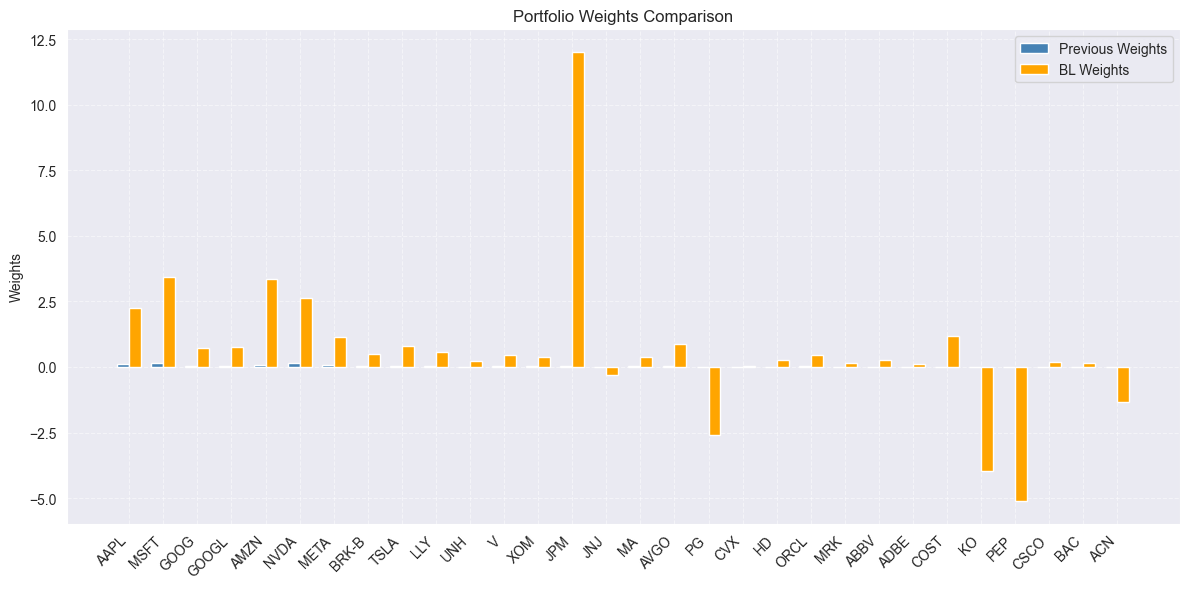

In [244]:
# Reverse optimization
inv_Sigma_BL = np.linalg.inv(Sigma_BL)
w_BL = np.dot(inv_Sigma_BL, mu_BL) / delta

# Weights Comparison
weights_compare_df = pd.DataFrame(
    {
        "Ticker": stock_tickers_list,
        "Previous Weights": w,
        "BL Weights": w_BL
    }
)

weights_compare_df.set_index("Ticker", inplace=True)

# Crear el gráfico de barras
x = np.arange(len(weights_compare_df))  # posiciones para cada barra
width = 0.35  # ancho de cada barra

fig, ax = plt.subplots(figsize=(12, 6))

# Barras para pesos anteriores (azul)
bars1 = ax.bar(x - width/2, weights_compare_df["Previous Weights"], width, label='Previous Weights', color='steelblue')

# Barras para pesos de Black-Litterman (naranja)
bars2 = ax.bar(x + width/2, weights_compare_df["BL Weights"], width, label='BL Weights', color='orange')

# Etiquetas y estilo
ax.set_ylabel("Weights")
ax.set_title("Portfolio Weights Comparison")
ax.set_xticks(x)
ax.set_xticklabels(weights_compare_df.index, rotation=45, ha="right")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [289]:
weights_compare_df["BL Weights"].sum()

20.000000000000583

In [284]:
# Ajuste de Black Litterman

# Definimos función objetivo
def objective(weights): 
    """
    The target is minimizing the quadratic error between weights and BL weights
    """
    diff = weights - w_BL
    return np.dot(diff, diff)

# Punto de partida
init_guess = w_BL

# Incorporamos un tracking error en las restricciones para que la cartera no se desvíe mucho del benchmark
benchmark_returns = pd.read_csv("data/processed_data/vti_returns.csv", index_col='Date')

def tracking_error(w, stock_returns, benchmark_returns):
    portfolio_returns = stock_returns.values @ w
    track_error = np.std(portfolio_returns - benchmark_returns.values)
    return track_error

def tracking_error_constraint(weights):
    track_error  = tracking_error(weights, stock_returns, benchmark_returns)
    constraint = 0.25 - track_error # 0.25 desv tipicas mensuales
    return constraint


# Construimos diccionario de restricciones
constraints = [
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}, # Equality -> == 0
    {'type': 'ineq', 'fun': tracking_error_constraint} # Inequality -> >=0
]

# Establecemos límites para la solución (Posiciones de venta cortas, Diversificación)
bounds = ((0,0.) for asset in range(len(w_BL)))

solution = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)


In [285]:
solution

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 229.1200178030872
       x: [ 1.500e-01  1.500e-01 ...  0.000e+00  0.000e+00]
     nit: 3
     jac: [-4.173e+00 -6.535e+00 ... -3.181e-01  2.649e+00]
    nfev: 94
    njev: 3

In [291]:
# calculating the tracking error for the optimized portfolio
w_BL_constrained = np.round(solution.x,4)
te = tracking_error(solution.x, stock_returns, benchmark_returns)

print("BL Weights Constrained")
print("-"*70)
print(w_BL_constrained)
print('-'*70)
print(f"Total Weight Sum: {w_BL_constrained.sum()}")
print(f"Tracking Error: {te}")



BL Weights Constrained
----------------------------------------------------------------------
[0.15   0.15   0.     0.     0.15   0.15   0.1022 0.     0.     0.
 0.     0.     0.     0.15   0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.1478 0.     0.     0.     0.     0.    ]
----------------------------------------------------------------------
Total Weight Sum: 0.9999999999999998
Tracking Error: 0.07438070801421169


In [312]:
with open('data/estimators/weights_BL.pickle', 'wb') as handle:
    pickle.dump(w_BL_constrained, handle, protocol=pickle.HIGHEST_PROTOCOL)

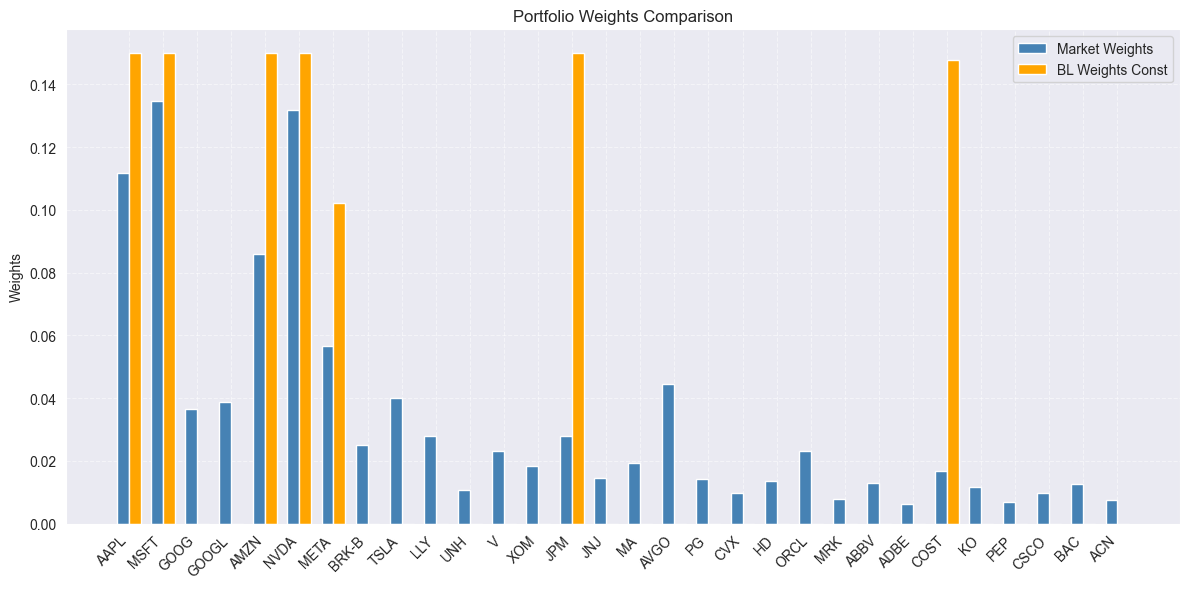

In [292]:
# Weights Comparison
weights_compare_df = pd.DataFrame(
    {
        "Ticker": stock_tickers_list,
        "Previous Weights": w,
        "BL Weights": w_BL,
        "BL Weights Constrained": w_BL_constrained
    }
)

weights_compare_df.set_index("Ticker", inplace=True)

# Crear el gráfico de barras
x = np.arange(len(weights_compare_df))  # posiciones para cada barra
width = 0.35  # ancho de cada barra

fig, ax = plt.subplots(figsize=(12, 6))

# Barras para pesos anteriores (azul)
bars1 = ax.bar(x - width/2, weights_compare_df["Previous Weights"], width, label='Market Weights', color='steelblue')

# Barras para pesos de Black-Litterman (naranja)
bars2 = ax.bar(x + width/2, weights_compare_df["BL Weights Constrained"], width, label='BL Weights Const', color='orange')

# Etiquetas y estilo
ax.set_ylabel("Weights")
ax.set_title("Portfolio Weights Comparison")
ax.set_xticks(x)
ax.set_xticklabels(weights_compare_df.index, rotation=45, ha="right")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

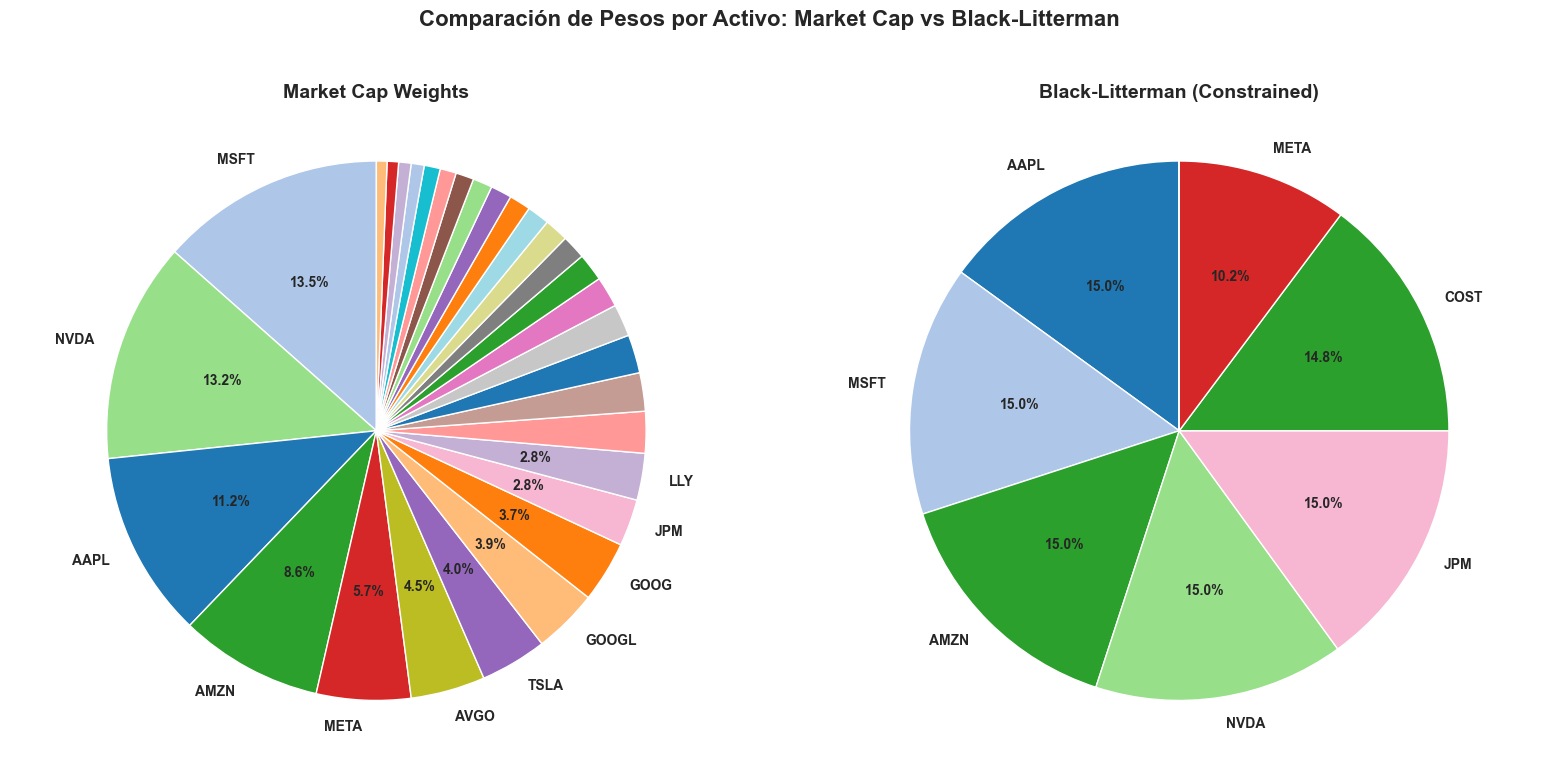

In [347]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ---- FILTRADO Y ORDEN ----
# Añadimos una columna con colores consistentes
num_assets = len(weights_compare_df)
base_colors = plt.cm.tab20.colors 
colors = (base_colors * ((num_assets // len(base_colors)) + 1))[:num_assets]
weights_compare_df["Color"] = colors[:len(weights_compare_df)]

# ORDEN individual por peso en cada cartera
sorted_prev = weights_compare_df.sort_values("Previous Weights", ascending=False)
sorted_bl = weights_compare_df.sort_values("BL Weights Constrained", ascending=False)

# ---- FUNCIONES DE ETIQUETADO ----
def autopct_threshold(values, threshold=2.8):
    def func(pct):
        total = sum(values)
        value = pct * total / 100.0
        return f'{pct:.1f}%' if value > threshold / 100 * total else ''
    return func

def label_threshold(names, values, threshold=2.8):
    labels = []
    for name, value in zip(names, values):
        if value >= threshold / 100:
            labels.append(name)
        else:
            labels.append('')
    return labels

# ---- GRÁFICO ----
fig, axes = plt.subplots(1, 2, figsize=(16, 8), facecolor='white')

# Pie Chart 1: Previous Weights
axes[0].pie(
    sorted_prev["Previous Weights"],
    labels=label_threshold(sorted_prev.index, sorted_prev["Previous Weights"]),
    colors=sorted_prev["Color"],
    autopct=autopct_threshold(sorted_prev["Previous Weights"]),
    startangle=90,
    textprops={'fontsize': 10, 'weight': 'bold'}
)
axes[0].set_title("Market Cap Weights", fontsize=14, weight='bold')

# Pie Chart 2: BL Weights Constrained
axes[1].pie(
    sorted_bl["BL Weights Constrained"],
    labels=label_threshold(sorted_bl.index, sorted_bl["BL Weights Constrained"]),
    colors=sorted_bl["Color"],
    autopct=autopct_threshold(sorted_bl["BL Weights Constrained"]),
    startangle=90,
    textprops={'fontsize': 10, 'weight': 'bold'}
)
axes[1].set_title("Black-Litterman (Constrained)", fontsize=14, weight='bold')

# Estilo general
for ax in axes:
    ax.axis('equal')  # círculos perfectos

plt.suptitle("Comparación de Pesos por Activo: Market Cap vs Black-Litterman", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [269]:
top_positive_alpha

,Alpha,Var_Residuos,R2
"(COST, BAC)",0.002622,0.002714,0.603901
"(MSFT, BAC)",0.002232,0.002577,0.588900
"(JPM, KO)",0.010121,0.001942,0.572079
"(JPM, PEP)",0.011035,0.002008,0.565416
"(JPM, PG)",0.008708,0.002342,0.556523
"(AMZN, PEP)",0.004313,0.003531,0.527231
"(BAC, ACN)",0.005443,0.002658,0.520725
"(AMZN, JNJ)",0.003075,0.003743,0.519534
"(AMZN, XOM)",0.000015,0.005512,0.517263
"(AMZN, CVX)",0.001250,0.005225,0.516004


## Expected Sharpe Ratio

In [309]:
portfolio_BL_returns = (stock_returns @ w_BL_constrained)
expected_BL_returns = np.mean(portfolio_BL_returns)
std_BL_returns = np.std(portfolio_BL_returns)
sharpe_BL_returns = (expected_BL_returns - variables['RiskFree'])/std_BL_returns
print(f"BL Weights Portfolio Sharpe: {sharpe_BL_returns}")


BL Weights Portfolio Sharpe: 0.30173994501258206


In [310]:
portfolio_BL_returns = (stock_returns @ weights_compare_df["Previous Weights"].values)
expected_BL_returns = np.mean(portfolio_BL_returns)
std_BL_returns = np.std(portfolio_BL_returns)
sharpe_BL_returns = (expected_BL_returns - variables['RiskFree'])/std_BL_returns
print(f"Previous Weights Portfolio Sharpe: {sharpe_BL_returns}")

Previous Weights Portfolio Sharpe: 0.29932929324644947


In [329]:
ew_array = np.full(30, 1/30)
portfolio_BL_returns = (stock_returns @ ew_array)
expected_BL_returns = np.mean(portfolio_BL_returns)
std_BL_returns = np.std(portfolio_BL_returns)
sharpe_BL_returns = (expected_BL_returns - variables['RiskFree'])/std_BL_returns
print(f"Equal Weights Portfolio Sharpe: {sharpe_BL_returns}")

Equal Weights Portfolio Sharpe: 0.24782641181366882


In [311]:

print(f"Benchmark Sharpe: {variables['SharpeRatio']}")

Benchmark Sharpe: 0.1301


# Backtesting

In [374]:
mktCap = pd.read_csv("data/processed_data/relative_market_caps.csv", index_col='Unnamed: 0')

In [334]:
riskfree_df = pd.read_csv("data/processed_data/monthly_yield_curve.csv",index_col='Date')
riskfree_df

,3,6,12,24,36,60,84,120,240,360
Date,,,,,,,,,,
2014-01-31,0.02,0.06,0.10,0.34,0.69,1.49,2.13,2.67,3.35,3.61
2014-02-28,0.05,0.08,0.12,0.33,0.69,1.51,2.13,2.66,3.31,3.59
2014-03-31,0.05,0.07,0.13,0.44,0.90,1.73,2.30,2.73,3.31,3.56
2014-04-30,0.03,0.05,0.11,0.42,0.87,1.69,2.25,2.67,3.22,3.47
2014-05-31,0.04,0.06,0.10,0.37,0.79,1.54,2.06,2.48,3.05,3.33
...,...,...,...,...,...,...,...,...,...,...
2025-02-28,4.32,4.25,4.08,3.99,3.99,4.03,4.14,4.24,4.55,4.51
2025-03-31,4.32,4.23,4.03,3.89,3.89,3.96,4.09,4.23,4.62,4.59
2025-04-30,4.31,4.19,3.85,3.60,3.58,3.72,3.93,4.17,4.68,4.66


In [515]:
# Ajuste de Black Litterman

def bl_weights_adjustment(w_BL):
    """
    Optimiza una cartera minimizando el error cuadrático respecto a los pesos BL,
    sujeto a restricciones de suma de pesos y tracking error.
    
    Parámetros:
    - w_BL: np.ndarray, pesos de Black-Litterman (vector de referencia)
    - stock_returns: pd.DataFrame, retornos históricos de los activos
    - benchmark_returns: pd.Series o pd.DataFrame, retornos del benchmark
    - tracking_error_max: float, máximo tracking error permitido
    
    Devuelve:
    - np.ndarray, pesos optimizados
    """

    def objective(weights): 
        diff = weights - w_BL
        return np.dot(diff, diff)


    # Restricciones
    constraints = [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    ]

    # Límites: no se permite short selling
    bounds = [(0, 0.25) for _ in range(len(w_BL))]

    # Punto inicial: w_BL
    init_guess = w_BL

    # Optimización
    solution = minimize(
        objective,
        init_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    if not solution.success:
        raise ValueError(f"Optimization failed: {solution.message}")

    return solution.x

In [516]:
def portfolio_return_statistics(portfolio_returns, rf):
    
    expected_returns = np.mean(portfolio_returns)
    std_returns = np.std(portfolio_returns)
    sharpe_returns = (expected_returns - rf)/std_returns

    output = {
        'Exp': expected_returns,
        'Std': std_returns,
        'Sharpe': sharpe_returns
    }
    return output

In [517]:
def portfolio_backtesting_results(returns_df, riskfree_df , dates, um=100):

    n_months = len(dates)
    n_year = int(n_months/12)
    # Month RF Rate
    actual_rf = riskfree_df.iloc[-1]['120'] / 100 / 12

    # Get Returns
    benchmark_returns = returns_df['Benchmark']
    BlPortReturns = returns_df['BL']
    EwPortReturns = returns_df['EW']

    ## Comparison: Benchmark Index vs Black Litterman vs Equally Weighted
    benchmark_statistics = portfolio_return_statistics(benchmark_returns,actual_rf)
    bl_statistics = portfolio_return_statistics(BlPortReturns,actual_rf)
    ew_statistics = portfolio_return_statistics(EwPortReturns,actual_rf)


    # Portfolio Values - Starting 100 u.m.
    # Benchmark
    benchmark_pf_value = um * np.cumprod(1+benchmark_returns)
    benchmark_pf_value = np.insert(benchmark_pf_value, 0, 100)
    # BlackLitterman 
    bl_pf_value = um * np.cumprod(1+BlPortReturns)
    bl_pf_value = np.insert(bl_pf_value, 0, 100)
    # Equally Weigthed Portfolio
    ew_pf_value = um * np.cumprod(1+EwPortReturns)
    ew_pf_value = np.insert(ew_pf_value, 0, 100)

    dates = pd.to_datetime(dates)
    initial_date = dates[0] - pd.DateOffset(months=1)
    full_dates = pd.DatetimeIndex([initial_date] + list(dates))

    values = pd.DataFrame({
        "Benchmark": benchmark_pf_value,
        "BL": bl_pf_value,
        "EW": ew_pf_value
    }, index=full_dates)


    rf_annual = (1 + actual_rf)**12 - 1      # tasa libre de riesgo anualizada

    # === 1. Benchmark Portfolio ===
    ann_ret_benchmark = ((benchmark_pf_value[-1] / 100) ** (1 / n_year)) - 1
    ann_std_benchmark = np.std(benchmark_returns) * np.sqrt(12)
    sharpe_benchmark = (ann_ret_benchmark - rf_annual) / ann_std_benchmark

    # === 2. Black-Litterman Portfolio ===
    ann_ret_bl = ((bl_pf_value[-1] / 100) ** (1 / n_year)) - 1
    ann_std_bl = np.std(BlPortReturns) * np.sqrt(12)
    sharpe_bl = (ann_ret_bl - rf_annual) / ann_std_bl

    # === 3. Equally Weighted Portfolio ===
    ann_ret_ew = ((ew_pf_value[-1] / 100) ** (1 / n_year)) - 1
    ann_std_ew = np.std(EwPortReturns) * np.sqrt(12)
    sharpe_ew = (ann_ret_ew - rf_annual) / ann_std_ew

    # === Redondeo para presentación ===
    ann_ret_benchmark = round(ann_ret_benchmark * 100, 4)
    ann_std_benchmark = round(ann_std_benchmark * 100, 4)
    sharpe_benchmark = round(sharpe_benchmark, 4)

    ann_ret_bl = round(ann_ret_bl * 100, 4)
    ann_std_bl = round(ann_std_bl * 100, 4)
    sharpe_bl = round(sharpe_bl, 4)

    ann_ret_ew = round(ann_ret_ew * 100, 4)
    ann_std_ew = round(ann_std_ew * 100, 4)
    sharpe_ew = round(sharpe_ew, 4)

    # === Tabla comparativa ===
    summary_df = pd.DataFrame({
    "Portfolio": ["Benchmark", "Black-Litterman", "Equally Weighted"],
    "Annual Return (%)": [ann_ret_benchmark, ann_ret_bl, ann_ret_ew],
    "Annual Volatility (%)": [ann_std_benchmark, ann_std_bl, ann_std_ew],
    "Annual Sharpe Ratio": [sharpe_benchmark, sharpe_bl, sharpe_ew]
    })

    print(summary_df)

    return values


In [383]:
def plot_backtest_values(bl_pf_value, benchmark_pf_value, ew_pf_value,
                         BlPortReturns, BT_benchmark_returns, weights_mkcap, number_of_months):
    """
    Plots the cumulative value of the benchmark, Black-Litterman and Equally Weighted portfolios.
    Includes historical tracking error.
    """
    # === Calcular Tracking Error histórico ===
    te = round(np.std(BlPortReturns - BT_benchmark_returns) * 100, 2)

    # === Crear figura ===
    plt.figure(figsize=(15, 5))

    # === Trazar los portafolios ===
    plt.plot(bl_pf_value, label=f'Black-Litterman Fund Value (Tracking Error: {te}%)', linewidth=2)
    plt.plot(benchmark_pf_value, label='Benchmark Index (e.g., VTI)', linewidth=2)
    plt.plot(ew_pf_value, label='Equally Weighted Portfolio', linewidth=2)

    # === Título ===
    plt.title("Backtest: Fund Value vs Benchmark vs Equally Weighted", fontsize=15)

    # === Eje x con fechas ===
    plt.xticks(ticks=range(0, len(bl_pf_value)))

    # === Etiquetas de ejes ===
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (starting at 100 u.m.)')

    # === Leyenda y estilo ===
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    # === Mostrar gráfico ===
    plt.show()

    return benchmark_pf_value, bl_pf_value

In [518]:
def BacktestingBL(weights_mktcap, stock_returns, factor_returns, benchmark_returns, riskfree_df, tau, number_of_views = 5, n_year = 4, um = 100):

    # Necessary variables
    ticker_list = list(stock_returns.columns)
    ew_array = np.full(len(ticker_list), 1/len(ticker_list))
    # Get number of months
    number_of_months = 12*n_year

    ## LOOP ##

    # Backtested Returns of the portfolios: Black Litterman vs EquallyWeighted
    BlPortReturns = np.zeros(number_of_months)
    EwPortReturns = np.zeros(number_of_months)


    for month in range(number_of_months):

        # Progress shown
        percentage_advancement = ((month+ 1) / number_of_months) * 100
        

        # Starting Point
        starting_index = (number_of_months + 1) - month
        test_date = stock_returns.index[-starting_index]
        print(f'Testeando mes: {month+1}/{number_of_months} - Fecha: {test_date} - Index: {starting_index}')
        # Current weights at starting point
        current_weights = weights_mktcap.iloc[-starting_index,:]

        # Get Returns: Tienen que ser previos al momento de hacer backtesting (Forward Looking Bias)
        # Current stock returns, previous to starting point
        current_stocks_returns = stock_returns.iloc[:-starting_index,:] # Get all rows, except the last starting_index columns
        print("Backtest Data: ", current_stocks_returns.index[0], " to ", current_stocks_returns.index[-1])
        # Current factor returns
        current_factor_returns = factor_returns.iloc[:-starting_index,:]
        # Benchmark index returns
        current_benchmark_returns = benchmark_returns.iloc[:-starting_index,:]

        # Get Current Risk Free Rate 10-Year yield from US Treasury (Monthly)
        current_rf = riskfree_df.iloc[-starting_index,:]['120'] / 100 / 12

        # Calculate current delta
        current_delta = ((np.mean(current_benchmark_returns) - current_rf) / np.var(current_benchmark_returns)).values[0]

        # Get Current Sigma (Var-Covar Matrix)
        # En cada iteración, el valor se modifica al incorporar nueva información
        current_Sigma = current_stocks_returns.cov()


        #### Black-Litterman Framework ####

        # Get parameters
        current_pi = implied_returns_func(current_delta,current_Sigma,current_weights)
        top_positive_alpha = get_views(current_stocks_returns, current_factor_returns,number_of_views)
        processed_views = processing_views(ticker_list,top_positive_alpha)

        # Bayesian Model
        output = BlackLittermanFunction(current_pi,current_Sigma,processed_views['P'],processed_views['Q'],tau,processed_views['Omega'])
        mu_BL, Sigma_BL = output['mu_BL'], output['Sigma_BL']
        # Get BL weights - Reverse Optimization
        inv_Sigma_BL = np.linalg.inv(Sigma_BL)
        bl_weights = np.dot(inv_Sigma_BL, mu_BL) / current_delta

        # Weight rebalancing
        adjusted_weights = bl_weights_adjustment(bl_weights)

        # Calculating returns
        print("Return Index: ", (stock_returns.iloc[-starting_index].name))
        current_BLportfolio_returns = (stock_returns.iloc[-starting_index] @ adjusted_weights)
        current_EWportfolio_returns = (stock_returns.iloc[-starting_index] @ ew_array)

        BlPortReturns[month], EwPortReturns[month] = current_BLportfolio_returns, current_EWportfolio_returns

    ## END LOOP ##
    

    dates = benchmark_returns.index[-number_of_months:]


    returns_df = pd.DataFrame({
        "Benchmark": benchmark_returns.values[-number_of_months:].flatten(),
        "BL": BlPortReturns,
        "EW": EwPortReturns
    }, index=dates)

    values = portfolio_backtesting_results(returns_df, riskfree_df, dates, um)

    return returns_df, values, adjusted_weights




In [519]:
resultados = BacktestingBL(mktCap,stock_returns,factor_returns,benchmark_returns, riskfree_df, tau, number_of_views = 5, n_year = 1, um = 100)

Testeando mes: 1/12 - Fecha: 2024-06 - Index: 13
Backtest Data:  2014-06  to  2024-05
Return Index:  2024-06
Testeando mes: 2/12 - Fecha: 2024-07 - Index: 12
Backtest Data:  2014-06  to  2024-06
Return Index:  2024-07
Testeando mes: 3/12 - Fecha: 2024-08 - Index: 11
Backtest Data:  2014-06  to  2024-07
Return Index:  2024-08
Testeando mes: 4/12 - Fecha: 2024-09 - Index: 10
Backtest Data:  2014-06  to  2024-08
Return Index:  2024-09
Testeando mes: 5/12 - Fecha: 2024-10 - Index: 9
Backtest Data:  2014-06  to  2024-09
Return Index:  2024-10
Testeando mes: 6/12 - Fecha: 2024-11 - Index: 8
Backtest Data:  2014-06  to  2024-10
Return Index:  2024-11
Testeando mes: 7/12 - Fecha: 2024-12 - Index: 7
Backtest Data:  2014-06  to  2024-11
Return Index:  2024-12
Testeando mes: 8/12 - Fecha: 2025-01 - Index: 6
Backtest Data:  2014-06  to  2024-12
Return Index:  2025-01
Testeando mes: 9/12 - Fecha: 2025-02 - Index: 5
Backtest Data:  2014-06  to  2025-01
Return Index:  2025-02
Testeando mes: 10/12 - F

In [514]:
stock_returns

,AAPL,MSFT,GOOG,GOOGL,AMZN,NVDA,META,BRK-B,TSLA,LLY,...,ORCL,MRK,ABBV,ADBE,COST,KO,PEP,CSCO,BAC,ACN
2014-06,0.032856,0.025423,0.027117,0.022521,0.038384,-0.019913,0.061126,-0.013966,0.144457,0.046145,...,-0.036103,-0.000173,0.038102,0.114368,-0.004383,0.034830,0.011369,0.009299,0.015078,-0.007517
2014-07,0.028326,0.034414,-0.006418,-0.008796,-0.036977,-0.057730,0.076642,-0.008969,-0.072373,-0.018015,...,-0.003460,-0.011864,-0.075417,-0.043931,0.020456,-0.067742,-0.006524,0.015176,-0.007195,-0.019486
2014-08,0.069690,0.051258,0.000000,0.004837,0.079947,0.105646,0.029432,0.090056,0.188794,0.040127,...,0.030741,0.057696,0.062206,0.037553,0.032700,0.060011,0.048628,-0.001953,0.053618,0.022204
2014-09,-0.012259,0.026491,0.010026,0.010335,-0.050201,-0.048369,0.054869,0.006464,-0.105566,0.028109,...,-0.081489,-0.013904,0.043885,-0.038420,0.034419,0.022281,0.006466,0.007177,0.057952,0.003202
2014-10,0.069489,0.012646,-0.032173,-0.035531,-0.054098,0.057399,-0.052599,0.014517,-0.004046,0.022565,...,0.019915,-0.015597,0.094114,0.013352,0.062257,-0.011194,0.039659,-0.020613,0.009509,-0.002462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02,0.024444,-0.044512,-0.177160,-0.180774,-0.113019,0.039599,-0.030915,0.091994,-0.322795,0.126691,...,-0.021347,-0.068798,0.137472,0.002534,0.067791,0.114908,0.018280,0.063097,-0.004329,-0.095234
2025-03,-0.083915,-0.053942,-0.097443,-0.096344,-0.109515,-0.142030,-0.147855,0.035841,-0.122659,-0.106850,...,-0.172065,-0.027363,0.002341,-0.134079,-0.102106,0.005741,-0.023270,-0.038154,-0.099593,-0.110507
2025-04,-0.044321,0.051578,0.030530,0.027697,-0.031176,0.005062,-0.047745,0.001257,0.085029,0.084742,...,0.006488,-0.043536,-0.071307,-0.022545,0.050230,0.020254,-0.091871,-0.066669,-0.039054,-0.042186
2025-05,-0.056384,0.152465,0.071703,0.078336,0.105843,0.215624,0.165005,-0.056493,0.205293,-0.197731,...,0.165966,-0.103276,-0.037975,0.101623,0.044909,-0.006222,-0.030935,0.094647,0.101265,0.062335


In [521]:
resultados[2]

array([2.50000000e-01, 2.50000000e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.50000000e-01, 0.00000000e+00, 2.67563749e-14,
       0.00000000e+00, 2.74225087e-14, 5.65381075e-14, 3.39173134e-14,
       4.80171458e-14, 2.50000000e-01, 4.84612350e-14, 3.69149156e-14,
       0.00000000e+00, 4.82724971e-13, 6.63080701e-14, 5.41233725e-14,
       4.57411886e-14, 6.85007606e-14, 5.53446178e-14, 6.66133815e-14,
       0.00000000e+00, 7.13679116e-13, 7.45681294e-13, 6.51423360e-14,
       2.44304577e-13, 6.85840273e-14])

In [461]:
def plot_portfolio_values(value_df, returns_df):
    """
    Plotea la evolución del valor acumulado de los portafolios y muestra el tracking error del BL.
    
    Parameters:
    - value_df: DataFrame con los valores acumulados de cada portfolio. Índice de fechas.
    - returns_df: DataFrame con los rendimientos mensuales de cada portfolio.
    """

    # === Tracking Error del BL respecto al Benchmark ===
    tracking_error = np.std(returns_df["BL"] - returns_df["Benchmark"]) * np.sqrt(12)  # anualizado
    tracking_error = round(tracking_error * 100, 2)

    # === Crear figura ===
    plt.figure(figsize=(14, 6))

    # === Trazar los valores acumulados ===
    plt.plot(value_df.index, value_df["Benchmark"], label="Benchmark (VTI)", linewidth=2)
    plt.plot(value_df.index, value_df["BL"], label=f"Black-Litterman (TE: {tracking_error}%)", linewidth=2)
    plt.plot(value_df.index, value_df["EW"], label="Equally Weighted", linewidth=2)

    # === Título y etiquetas ===
    plt.title("Backtest: Fund Value vs Benchmark vs Equally Weighted", fontsize=15)
    plt.xlabel("Fecha")
    plt.ylabel("Valor Acumulado (u.m.)")

    # === Estilo ===
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # === Mostrar gráfico ===
    plt.show()

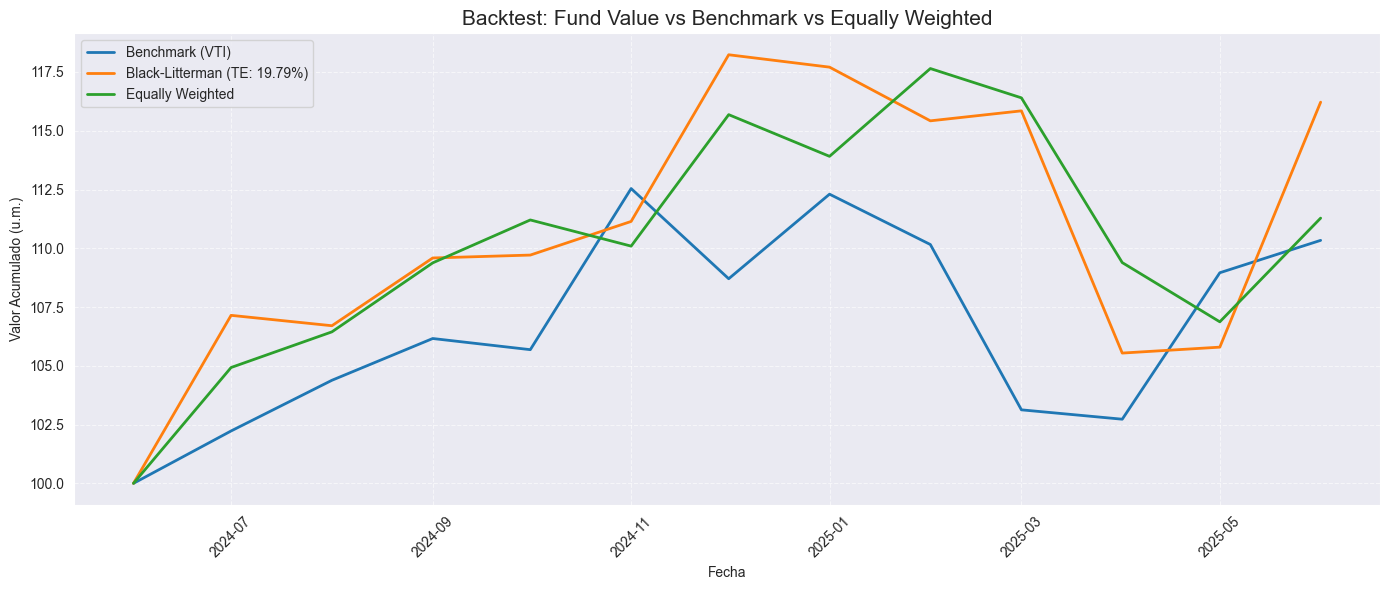

In [520]:
plot_portfolio_values(resultados[1], resultados[0])

In [524]:
resultados[1]

,Benchmark,BL,EW
2024-06-01,100.000000,100.000000,100.000000
2024-07-01,102.227882,107.146758,104.927511
2024-08-01,104.384025,106.705166,106.444247
2024-09-01,106.161165,109.587678,109.379791
2024-10-01,105.686590,109.711251,111.205156
2024-11-01,112.540806,111.141923,110.092140
2024-12-01,108.704280,118.233122,115.685200
2025-01-01,112.301638,117.706257,113.911888
2025-02-01,110.160170,115.422151,117.646859
2025-03-01,103.126777,115.846875,116.399803


In [493]:
all_returns = resultados[0]
all_returns

,Benchmark,BL,EW
Date,,,
2024-07,0.022279,-0.001828,0.049275
2024-08,0.021092,0.050799,0.014455
2024-09,0.017025,0.060384,0.027578
2024-10,-0.004470,-0.064017,0.016688
2024-11,0.064854,0.051123,-0.010009
2024-12,-0.034090,0.124133,0.050803
2025-01,0.033093,-0.040910,-0.015329
2025-02,-0.019069,0.108942,0.032788
2025-03,-0.063847,-0.004812,-0.010600


In [497]:
mapping_returns = factor_returns.loc[all_returns.index]
mapping_returns

,MARKET,VALUE,SIZE,VOLATILITY,GROWTH,MOMENTUM
Date,,,,,,
2024-07,-0.016324,0.101145,-0.019181,0.015257,0.039648,0.044859
2024-08,0.020093,-0.017030,0.032964,0.023097,0.048002,0.004081
2024-09,0.026782,0.003674,0.026943,0.017725,-0.000109,0.009306
2024-10,-0.002301,-0.010865,0.000442,-0.005901,-0.010091,-0.005294
2024-11,0.063257,0.105007,0.067388,0.057923,0.049430,0.062579
2024-12,0.008000,-0.090419,-0.045351,-0.027714,-0.062855,-0.081433
2025-01,0.020083,0.027640,0.060801,0.029862,0.039560,0.047608
2025-02,-0.036600,-0.053648,-0.003200,-0.012776,0.028095,0.010490
2025-03,-0.088745,-0.073245,-0.077554,-0.060335,-0.009669,-0.041418


In [504]:
np.var(mapping_returns.values, axis=0, ddof=1)

array([0.00198376, 0.00382941, 0.00247548, 0.00117484, 0.00107812,
       0.00178183])

## Risk measures

In [602]:
def mc_var_sim(cholesky_matrix, returns, posiciones, alpha):
    normal_simulation = norm.ppf(np.random.rand(returns.shape[0],len(posiciones)))
    correlated_normal_simulation = pd.DataFrame(np.matmul(cholesky_matrix, normal_simulation.T).T)
    PL = correlated_normal_simulation @ np.transpose(posiciones)
    VaR = - np.quantile(PL, alpha)
    ES = - np.mean(PL[PL < - VaR])
    return VaR, ES, correlated_normal_simulation.values

def simulations(num_sims, cholesky_matrix, returns, posiciones, alpha=0.01):
    mc_VaR = np.zeros(num_sims)
    mc_ES = np.zeros(num_sims)
    mc_sim_returns = np.zeros((returns.shape[0], returns.shape[1], num_sims))
    for i in range(num_sims):
        var , es, sim_returns = mc_var_sim(cholesky_matrix, returns, posiciones, alpha)
        mc_VaR[i], mc_ES[i], mc_sim_returns[:,:,i] = var, es, sim_returns
    
    VaR = round(max(np.mean(mc_VaR), 0), 2)
    ES = round(max(np.mean(mc_ES), 0), 2)

    print(mc_VaR.shape)

    output = {
        'VaR': VaR,
        'ES': ES,
        'Sim_Returns': mc_sim_returns
    }

    return output


In [525]:
def max_drawdown(valor_portfolio):
    valores = valor_portfolio.values
    cumulative_max = np.maximum.accumulate(valores)
    drawdowns = (cumulative_max - valores) / cumulative_max
    max_drawdown = np.max(drawdowns)
    return round(max_drawdown * 100, 2)

    

In [614]:
def plot_returns(simulated_returns, num_sims, positions, alpha, VaR, ES):
    avg_PnL = [simulated_returns[:, :, i] @ positions for i in range(num_sims)]
    avg_PnL = np.concatenate(avg_PnL)

    plt.figure(figsize=(10,5))
    plt.hist(avg_PnL, bins=100, color='skyblue', edgecolor='gray')
    plt.axvline(-VaR, color='red', linestyle='--', label=f'VaR ({int((1-alpha)*100)}%)')
    plt.axvline(-ES, color='orange', linestyle='--', label='ES')
    plt.title('Distribución simulada de P&L')
    plt.xlabel('Ganancia / Pérdida')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [582]:
resultados[0]

,Benchmark,BL,EW
Date,,,
2024-07,0.022279,0.071468,0.049275
2024-08,0.021092,-0.004121,0.014455
2024-09,0.017025,0.027014,0.027578
2024-10,-0.004470,0.001128,0.016688
2024-11,0.064854,0.013040,-0.010009
2024-12,-0.034090,0.063803,0.050803
2025-01,0.033093,-0.004456,-0.015329
2025-02,-0.019069,-0.019405,0.032788
2025-03,-0.063847,0.003680,-0.010600


In [615]:
def RiskMeasures(returns_df, factor_returns, stock_returns, valores_portfolio, posiciones, um=100 ,num_sims=1000, alpha=0.01):

    # Calcular Varianzas de cada uno de los factores
    factor_returns = factor_returns.loc[returns_df.index]
    returns_df = stock_returns.loc[returns_df.index]
    factor_variances = np.var(factor_returns.values, axis=0, ddof=1)
    F = np.diag(factor_variances)

    

    # Vector betas -> Factor Explained
    beta_factors = []
    for j in range(len(factor_returns.columns)):
        betas = []
        for i in range(len(returns_df.columns)):
            beta = np.cov(factor_returns.iloc[:,j], returns_df.iloc[:,i])[0,1] / factor_variances[j]
            betas.append(beta)
        beta_factors.append(betas)
    
    
    beta_factors = np.array(beta_factors)
    print(beta_factors.shape)
    print(F.shape)

    # Residuals
    residual_variance = np.zeros(returns_df.shape[1])
    for i in range(len(returns_df.columns)):
        y = returns_df.iloc[:, i].values  # retorno del activo i
        y_hat = factor_returns.values @ beta_factors[:, i]  # ajuste usando factores
        residuals = y - y_hat
        residual_variance[i] = np.var(residuals, ddof=1)
    
    eps = np.diag(residual_variance)

    # VarCovar Matrix -> Sigma = Beta*Var(F)*Beta.T + Var(eps)
    var_covar_matrix  = beta_factors.T @ F @ beta_factors + eps

    print(var_covar_matrix.shape)
    cholesky_matrix = np.linalg.cholesky(var_covar_matrix)


    # MonteCarlo simulation
    output = simulations(num_sims, cholesky_matrix, returns_df, posiciones*um, alpha)

    VaR, ES = output['VaR'], output['ES']
    

    # MaxDrawDown
    md_bl = max_drawdown(valores_portfolio['BL'])
    md_index = max_drawdown(valores_portfolio['Benchmark'])

    results_dict = {
        'VaR': VaR,
        'Es': ES,
        'ConfLevel': (1 - alpha),
        'Period': "1 Month",
        'Method': "Factor Model - Monte Carlo",
        'NumSims': num_sims,
        'Factors': factor_returns.columns,
        'FundMaxDrawdown %': md_bl,
        'IndexMaxDrawdown %': md_index
    }

    plot_returns(output['Sim_Returns'], num_sims, posiciones*um,alpha, VaR, ES)

    return results_dict



In [558]:
resultados[0]

,Benchmark,BL,EW
Date,,,
2024-07,0.022279,0.071468,0.049275
2024-08,0.021092,-0.004121,0.014455
2024-09,0.017025,0.027014,0.027578
2024-10,-0.004470,0.001128,0.016688
2024-11,0.064854,0.013040,-0.010009
2024-12,-0.034090,0.063803,0.050803
2025-01,0.033093,-0.004456,-0.015329
2025-02,-0.019069,-0.019405,0.032788
2025-03,-0.063847,0.003680,-0.010600


In [580]:
stock_returns

,AAPL,MSFT,GOOG,GOOGL,AMZN,NVDA,META,BRK-B,TSLA,LLY,...,ORCL,MRK,ABBV,ADBE,COST,KO,PEP,CSCO,BAC,ACN
2014-06,0.032856,0.025423,0.027117,0.022521,0.038384,-0.019913,0.061126,-0.013966,0.144457,0.046145,...,-0.036103,-0.000173,0.038102,0.114368,-0.004383,0.034830,0.011369,0.009299,0.015078,-0.007517
2014-07,0.028326,0.034414,-0.006418,-0.008796,-0.036977,-0.057730,0.076642,-0.008969,-0.072373,-0.018015,...,-0.003460,-0.011864,-0.075417,-0.043931,0.020456,-0.067742,-0.006524,0.015176,-0.007195,-0.019486
2014-08,0.069690,0.051258,0.000000,0.004837,0.079947,0.105646,0.029432,0.090056,0.188794,0.040127,...,0.030741,0.057696,0.062206,0.037553,0.032700,0.060011,0.048628,-0.001953,0.053618,0.022204
2014-09,-0.012259,0.026491,0.010026,0.010335,-0.050201,-0.048369,0.054869,0.006464,-0.105566,0.028109,...,-0.081489,-0.013904,0.043885,-0.038420,0.034419,0.022281,0.006466,0.007177,0.057952,0.003202
2014-10,0.069489,0.012646,-0.032173,-0.035531,-0.054098,0.057399,-0.052599,0.014517,-0.004046,0.022565,...,0.019915,-0.015597,0.094114,0.013352,0.062257,-0.011194,0.039659,-0.020613,0.009509,-0.002462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02,0.024444,-0.044512,-0.177160,-0.180774,-0.113019,0.039599,-0.030915,0.091994,-0.322795,0.126691,...,-0.021347,-0.068798,0.137472,0.002534,0.067791,0.114908,0.018280,0.063097,-0.004329,-0.095234
2025-03,-0.083915,-0.053942,-0.097443,-0.096344,-0.109515,-0.142030,-0.147855,0.035841,-0.122659,-0.106850,...,-0.172065,-0.027363,0.002341,-0.134079,-0.102106,0.005741,-0.023270,-0.038154,-0.099593,-0.110507
2025-04,-0.044321,0.051578,0.030530,0.027697,-0.031176,0.005062,-0.047745,0.001257,0.085029,0.084742,...,0.006488,-0.043536,-0.071307,-0.022545,0.050230,0.020254,-0.091871,-0.066669,-0.039054,-0.042186
2025-05,-0.056384,0.152465,0.071703,0.078336,0.105843,0.215624,0.165005,-0.056493,0.205293,-0.197731,...,0.165966,-0.103276,-0.037975,0.101623,0.044909,-0.006222,-0.030935,0.094647,0.101265,0.062335


(6, 30)
(6, 6)
(30, 30)
(1000,)


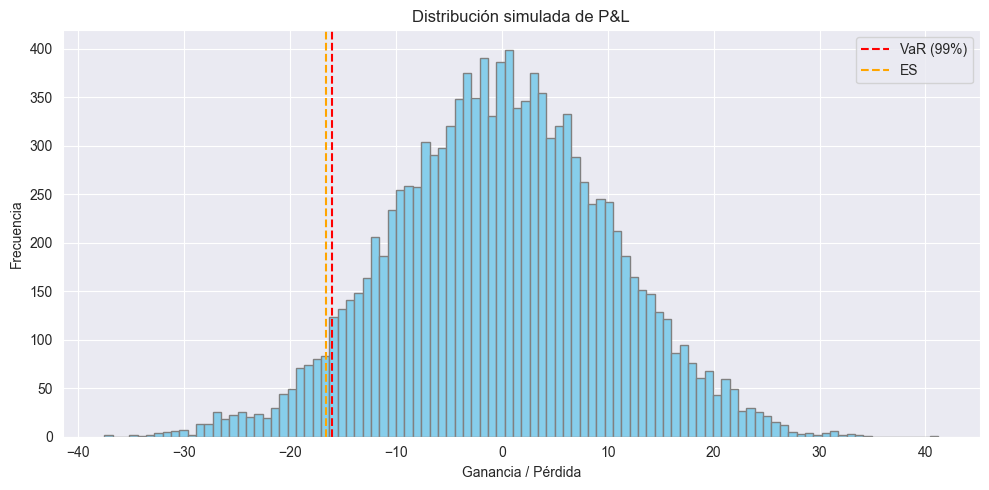

In [616]:
risk_resultados = RiskMeasures(resultados[0],factor_returns, stock_returns, resultados[1], resultados[2], num_sims=1000, alpha=0.01)

In [607]:
risk_resultados

{'VaR': 16.18,
 'Es': 16.76,
 'ConfLevel': 0.99,
 'Period': '1 Month',
 'Method': 'Factor Model - Monte Carlo',
 'NumSims': 1000,
 'Factors': Index(['MARKET', 'VALUE', 'SIZE', 'VOLATILITY', 'GROWTH', 'MOMENTUM'], dtype='object'),
 'FundMaxDrawdown %': 10.73,
 'IndexMaxDrawdown %': 8.72}